# Quant / Algo Trading on Bitcoin - Analysis and Backtesting

# Notebook 03 - Time Series Analysis and Forecasting

**By: [Jonathan Yeung](https://github.com/jonathan-yeung)**

In this notebook, I intend to analyze the time series data of BTC-USD with the Box-Jenkins Method and fit an ARIMA model to the data. I will also make point forecasts and interval forecasts using the selected ARIMA model.

---

# Imports

In [1]:
# data manipulation
import numpy as np
import pandas as pd
from itertools import product

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go

# stats
from scipy import stats
import statsmodels.api as sm
from statsmodels.api import tsa
from statsmodels.graphics.tsaplots import month_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse, meanabs
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# misc
import os
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [2]:
file_path = ""

In [3]:
check_file = os.path.isfile(file_path + "data/raw.csv")

check_file

True

In [4]:
df = pd.read_csv(file_path + "data/raw.csv")
df.drop(columns=["Open", "High", "Low", "Volume"], inplace=True)
df.rename(columns={"Close":"price"}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"], utc=True)
df.set_index("Date", inplace=True)

df.head()

,price
Date,
2014-09-17 00:00:00+00:00,457.334015
2014-09-18 00:00:00+00:00,424.440002
2014-09-19 00:00:00+00:00,394.795990
2014-09-20 00:00:00+00:00,408.903992
2014-09-21 00:00:00+00:00,398.821014


For the following analysis, I try to look at the monthly average data for both checking for any seasonality and ARIMA modelling.

Since the price data for Mar 2024 is not complete, I will use the price data up to Feb 2024 only for monthly average data.

In [5]:
df_monthly_btc = df.resample("MS").mean()
df_monthly_btc = df_monthly_btc[:-1]

df_monthly_btc.head()

,price
Date,
2014-09-01 00:00:00+00:00,407.182428
2014-10-01 00:00:00+00:00,364.148873
2014-11-01 00:00:00+00:00,366.099799
2014-12-01 00:00:00+00:00,341.267871
2015-01-01 00:00:00+00:00,248.782547


In [6]:
df_monthly_btc.tail()

,price
Date,
2023-10-01 00:00:00+00:00,29755.895161
2023-11-01 00:00:00+00:00,36596.164844
2023-12-01 00:00:00+00:00,42546.893523
2024-01-01 00:00:00+00:00,42919.612399
2024-02-01 00:00:00+00:00,49875.174300


Let's have a look at the price chart of the data.

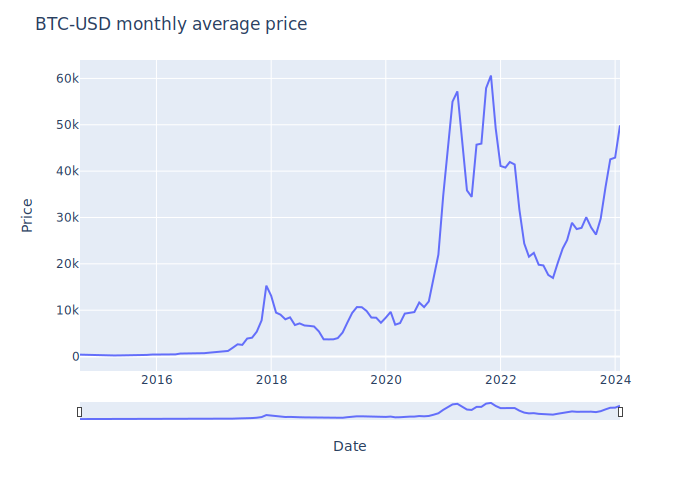

In [7]:
fig = px.line(df_monthly_btc, x=df_monthly_btc.index, y="price")

fig.update_layout(
    yaxis_title="Price",
    legend_title="Date",
    title="BTC-USD monthly average price",
    hovermode = "x unified"
)

fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness = 0.05)
fig.show(renderer="svg")

# Checking Seasonality

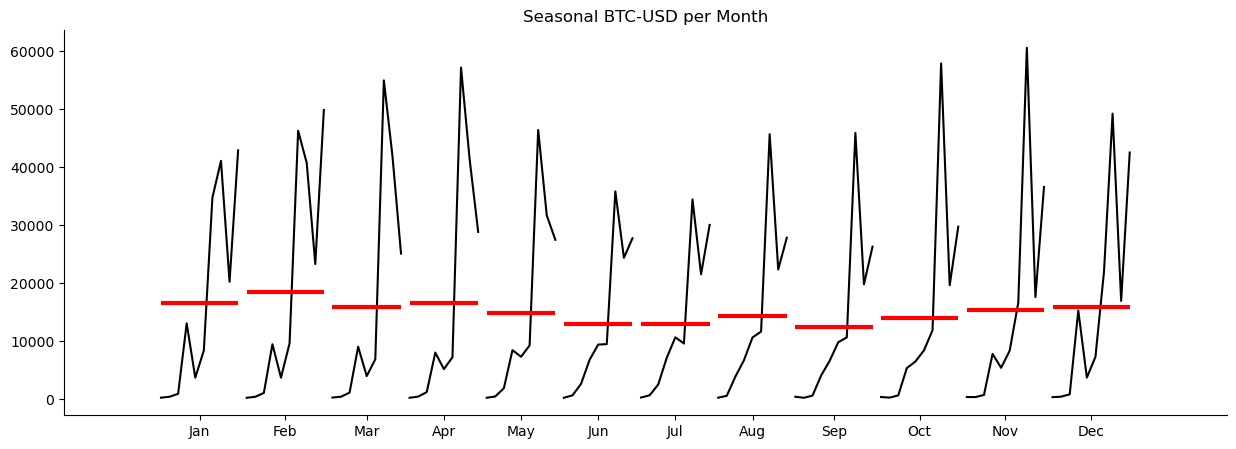

In [8]:
# Seasonal plot
plt.figure(figsize=(15, 5))

month_plot(df_monthly_btc["price"], ax=plt.gca())

plt.title("Seasonal BTC-USD per Month")
sns.despine()
plt.show()

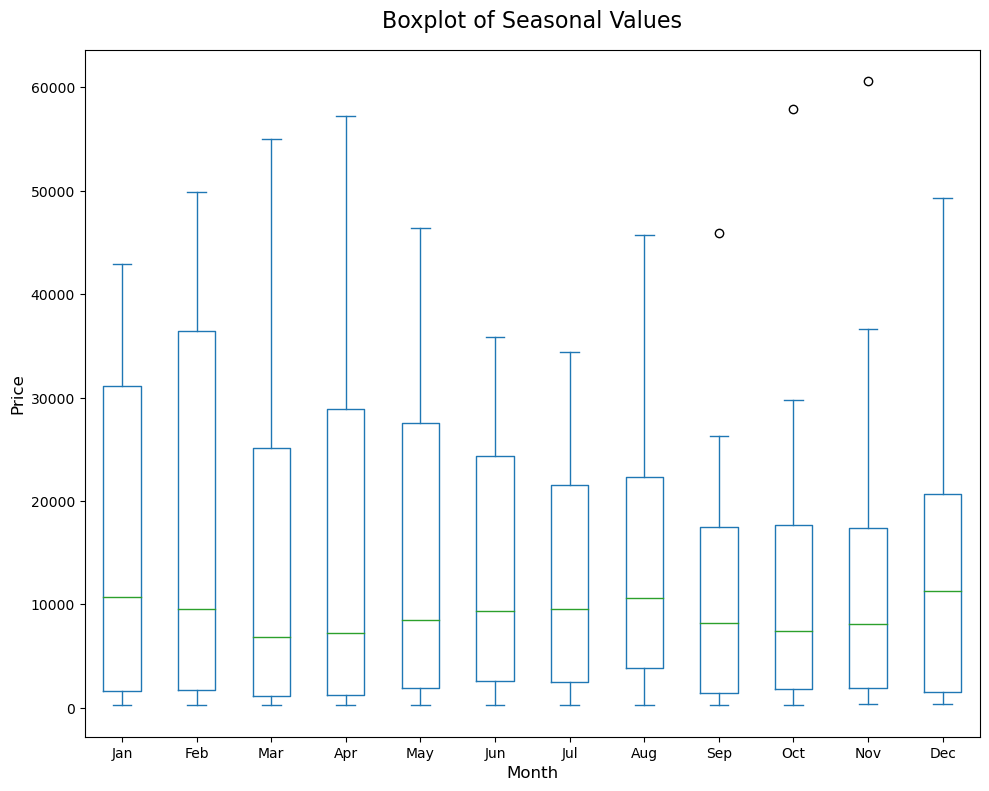

In [9]:
# Boxplot of seasonal values
df_seasonal_btc = df_monthly_btc.copy()

df_seasonal_btc['month'] = df_seasonal_btc.index.strftime('%b')
df_seasonal_btc['year'] = df_seasonal_btc.index.year

btc_piv = df_seasonal_btc.pivot(index='year', columns='month', values='price')

df_seasonal_btc = df_seasonal_btc.drop(['year', 'month'], axis=1)

# put months in order
month_names = pd.date_range(start='2000-01-01', periods=12, freq='MS').strftime('%b')
btc_piv = btc_piv.reindex(columns=month_names)

# plot it
fig, ax = plt.subplots(figsize=(10, 8))
btc_piv.plot(ax=ax, kind='box')

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Price', fontsize=12)
ax.set_title('Boxplot of Seasonal Values', fontsize=16, y=1.02)
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout()

From the seasonal plot and boxplot above, there is no obvious seasonality in terms of average or median price levels.

# Modelling

In the coming steps, I will use the Box-Jenkins Method for the time series analysis and forecasting.

Box-Jenkins Method comprises 3 main stages:
1. Visual Analysis, Unit Root Tests
2. Correlograms, ARIMA Fitting
3. Residual Diagnostics

After the analysis, I will use the optimized ARIMA model to make point forecasts and interval forecasts for BTC-USD.

In addition to in-sample evaluations, I will also use out-of-sample evaluations to diagnose the model. Hence, there is a need to split the time series data into two parts (in-sample data and held-out data) before the analysis.

## Train-Test Split

In-sample data (Train) : Held-out data (Test) = 80% : 20%

In [10]:
train_len = int(len(df_monthly_btc)*0.8)
test_len = len(df_monthly_btc) - train_len

train = df_monthly_btc[:train_len]
test = df_monthly_btc[train_len:]

print(f"size of dataset: {len(df_monthly_btc)}")
print(f"size of training set: {train_len}")
print(f"size of test set: {test_len}")
print(f"Date range of training set: {train.index[0].strftime('%b %Y')} to {train.index[-1].strftime('%b %Y')}")

size of dataset: 114
size of training set: 91
size of test set: 23
Date range of training set: Sep 2014 to Mar 2022


On the price chart, the data is split as such:

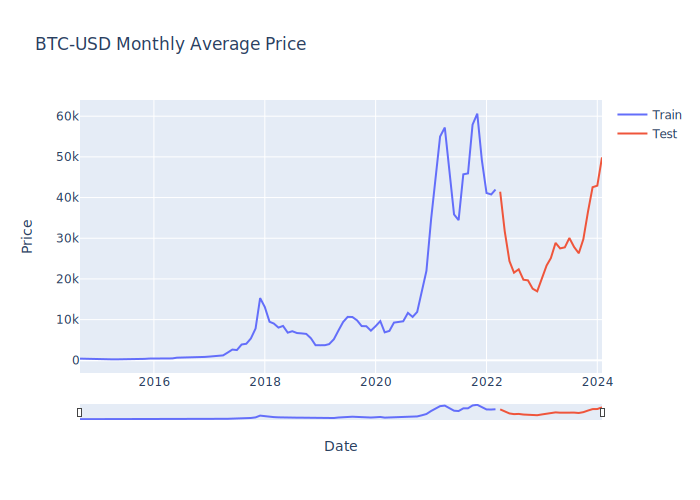

In [11]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train["price"], mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test["price"], mode='lines', name="Test"))

fig.update_layout(
    yaxis_title="Price",
    xaxis_title="Date",
    title="BTC-USD Monthly Average Price",
    hovermode="x unified"
)

fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness = 0.05)
fig.show(renderer="svg")

## 1. Visual Analysis, Unit Root Tests

In this part, I will do the following 3 steps:

- Visualization
- Transform the data: log transformation, differencing
- Unit Root Tests: ADF Test, KPSS Test (level stationary, trend stationary)

The unit root tests are carried out to test whether the transformed data is stationary, which is the crucial pre-requisite of ARIMA model fitting.

Let's visualize the in-sample data, which will be used for model selection and fitting.

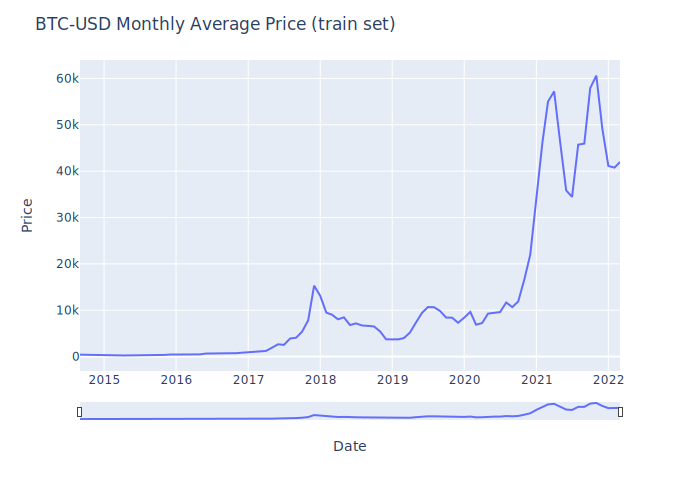

In [12]:
fig = px.line(train, x=train.index, y="price")

fig.update_layout(
    yaxis_title="Price",
    legend_title="Date",
    title="BTC-USD Monthly Average Price (train set)"
)

fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness = 0.05)
fig.show(renderer="svg")

Observations:

- no obvious seasonality
- increasing variance
- seemingly exponential growth

A log-transformation is needed, probably followed by a 1st-order differencing also.

In [13]:
train.loc[:, 'log_price'] = np.log(train['price'])
train.loc[:, 'diff_log'] = train['log_price'].diff(1)

train.head()

,price,log_price,diff_log
Date,,,
2014-09-01 00:00:00+00:00,407.182428,6.009261,NaN
2014-10-01 00:00:00+00:00,364.148873,5.897563,-0.111699
2014-11-01 00:00:00+00:00,366.099799,5.902906,0.005343
2014-12-01 00:00:00+00:00,341.267871,5.832668,-0.070238
2015-01-01 00:00:00+00:00,248.782547,5.516579,-0.316089


Let's have a look on the charts of log prices and differenced log prices.

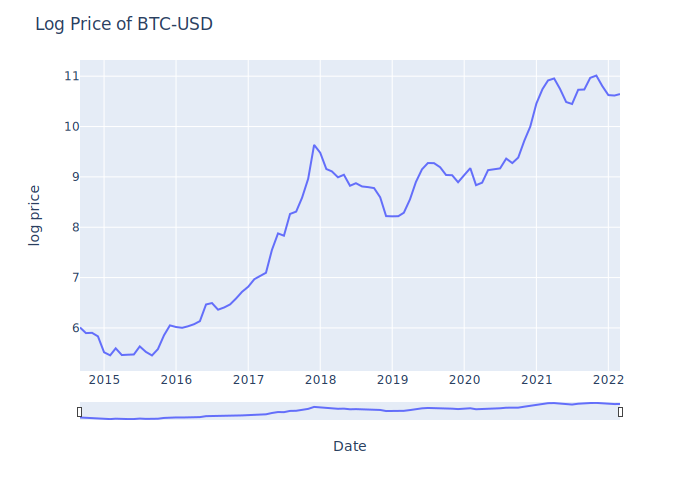

In [14]:
fig = px.line(train, x=train.index, y="log_price")

fig.update_layout(
    yaxis_title="log price",
    xaxis_title="Date",
    title="Log Price of BTC-USD"
)

fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness = 0.05)
fig.show(renderer="svg")

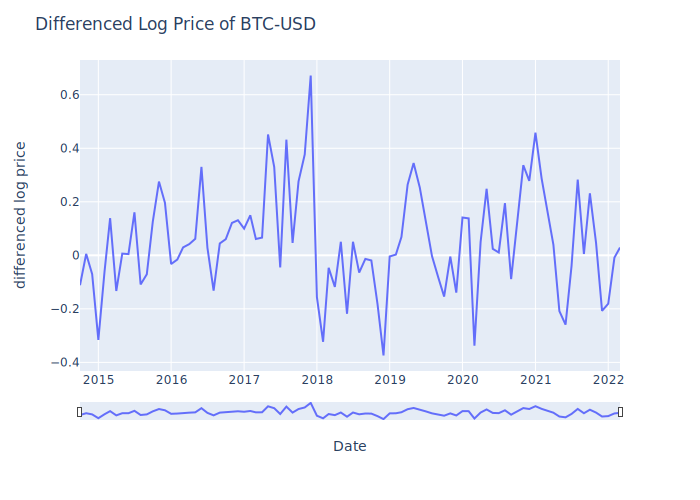

In [15]:
fig = px.line(train[1:], x=train[1:].index, y="diff_log")

fig.update_layout(
    yaxis_title="differenced log price",
    xaxis_title="Date",
    title="Differenced Log Price of BTC-USD"
)

fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness = 0.05)
fig.show(renderer="svg")

### Unit Root Tests (Formal Tests for Stationarity)

- ADF Test
- KPSS Test - level stationary, trend stationary

Both ADF Test and KPSS Test test for stationarity of the time series data, but they differ in the way they set up hypotheses.

For the ADF Test, the hypotheses are:

$H_0$ : A unit root is present (i.e. the series is NOT stationary) vs $H_1$ : A unit root is not present (i.e. the series is stationary)

For the KPSS Test, the hypotheses of level-stationary KPSS Test are:

$H_0$ : The series is stationary vs $H_1$ : The series is NOT stationary

There are two versions of KPSS tests. One is testing for level stationary, while another one is testing for trend stationary. Level stationarity refers to stationarity around a constant, while trend stationarity refers to stationarity around a linear trend.

In [16]:
# ADF Test
adf = tsa.stattools.adfuller(train['diff_log'][1:])

# KPSS Test - level stationary
kpss_c = tsa.stattools.kpss(train['diff_log'][1:], regression='c')

# KPSS Test - trend stationary
kpss_ct = tsa.stattools.kpss(train['diff_log'][1:], regression='ct')

print(f"Test for stationarity (ADF Test): stat = {adf[0]:.3f}, p-value = {adf[1]:.3f}")
print(f"\nTest for stationarity (KPSS Test - level stationary): stat = {kpss_c[0]:.3f}, p-value = {kpss_c[1]:.3f}")
print(f"\nTest for stationarity (KPSS Test - trend stationary): stat = {kpss_ct[0]:.3f}, p-value = {kpss_ct[1]:.3f}\n")

Test for stationarity (ADF Test): stat = -6.459, p-value = 0.000

Test for stationarity (KPSS Test - level stationary): stat = 0.075, p-value = 0.100

Test for stationarity (KPSS Test - trend stationary): stat = 0.076, p-value = 0.100



The p-value of the ADF Test is 0.0000, which is far less than 0.05. Therefore, we reject $H_0$ of the test at 5% significance level, i.e. the series should be stationary.

The p-values of the two KPSS Tests are 0.100, which is greater than 0.05. Therefore, we fail to reject $H_0$ of the tests at 5% significance level.

Summing up with the test results, the series should be stationary.

## 2. Correlograms, ARIMA Fitting

In this part, I will do the following steps:

- Making correlograms: ACF Plot, PACF Plot
- Choosing the best model with the least BIC (in-sample evaluations)

In order to fit an ARIMA(p, d, q) model, I need to determine the orders p, d and q.

The ACF Plot could give me a good initial estimate of the order q, while the PACF Plot could give me a good initial estimate of the order p.

### ACF Plot, PACF Plot

In [17]:
def tsplot(y, lags=None, title='', figsize=(14, 8)):

    '''
    Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    '''

    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    # chart of the series
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)

    # histogram
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')

    # ACF plot
    plot_acf(y, lags=lags, ax=acf_ax)
    acf_ax.set_xlabel('Lag')
    acf_ax.set_xticks(np.arange(0, lags+1, step=5))
    acf_ax.set_ylabel('Autocorrelation')

    # PACF plot
    plot_pacf(y, lags=lags, ax=pacf_ax)
    pacf_ax.set_xlabel('Lag')
    pacf_ax.set_xticks(np.arange(0, lags+1, step=5))
    pacf_ax.set_ylabel('Partial AC')

    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()

    return ts_ax, acf_ax, pacf_ax

(<Axes: title={'center': 'BTC-USD Log Price | Training set'}, xlabel='Date'>,
 <Axes: title={'center': 'Autocorrelation'}, xlabel='Lag', ylabel='Autocorrelation'>,
 <Axes: title={'center': 'Partial Autocorrelation'}, xlabel='Lag', ylabel='Partial AC'>)

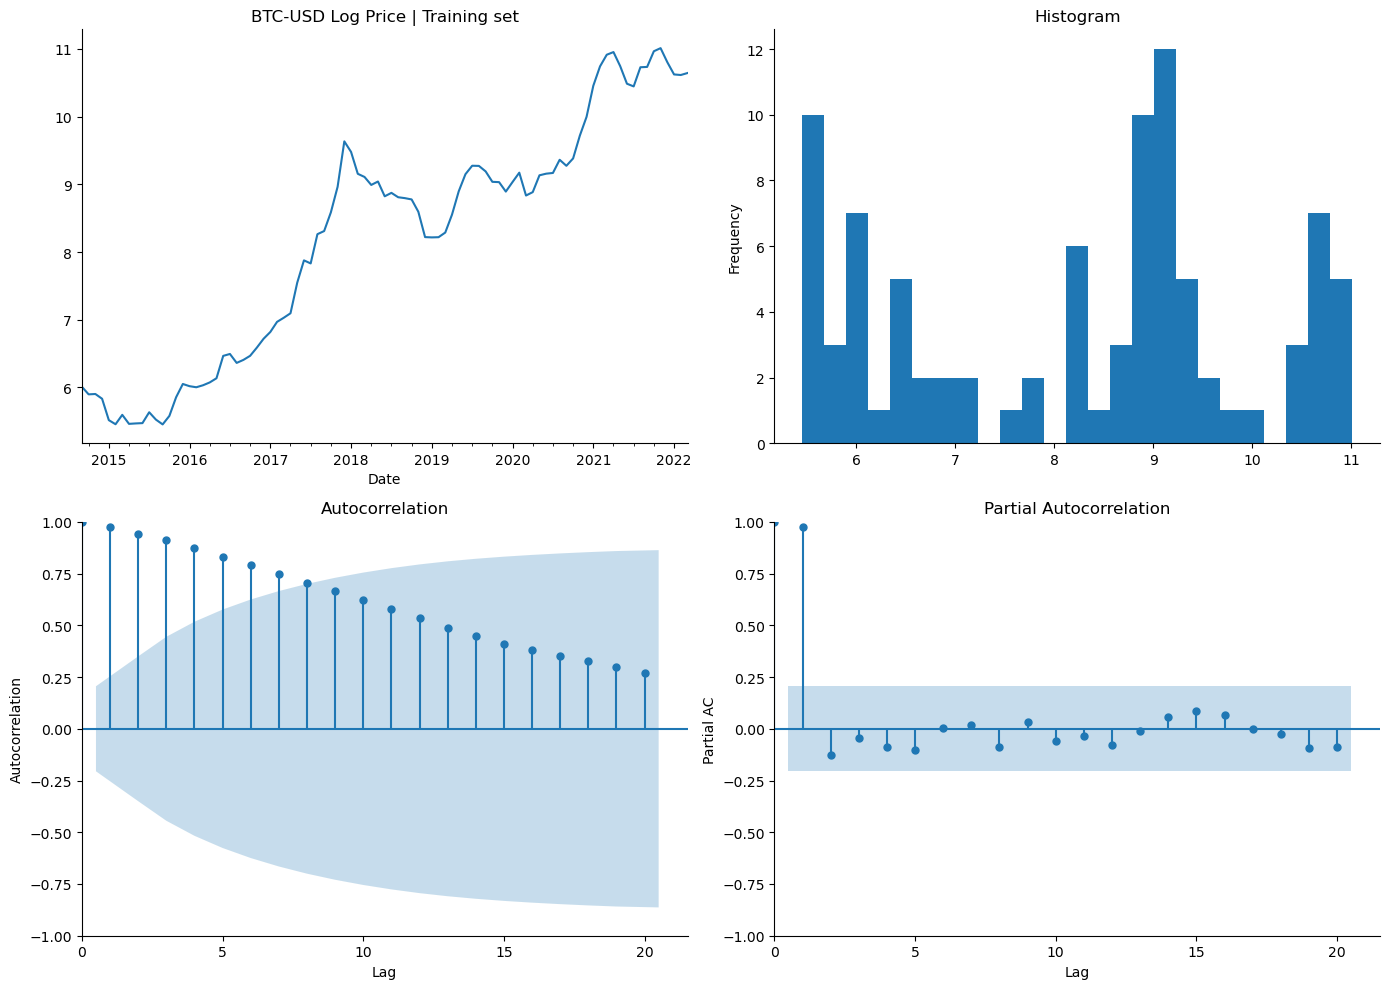

In [18]:
tsplot(train['log_price'], title='BTC-USD Log Price | Training set', lags=20, figsize=(14, 10))

From the histogram above, we can see that the distribution of the log prices does not seem to be a normal distribution.

In the ACF plot, the first 8 spikes lie beyond the bands and the autocorrelation drops gradually instead of exponenetially. It is still unclear to tell a good initial estimate of order q, and we might be able to see a clearer picture in the differenced time series.

(<Axes: title={'center': 'BTC-USD Differenced Log Price | Training set'}, xlabel='Date'>,
 <Axes: title={'center': 'Autocorrelation'}, xlabel='Lag', ylabel='Autocorrelation'>,
 <Axes: title={'center': 'Partial Autocorrelation'}, xlabel='Lag', ylabel='Partial AC'>)

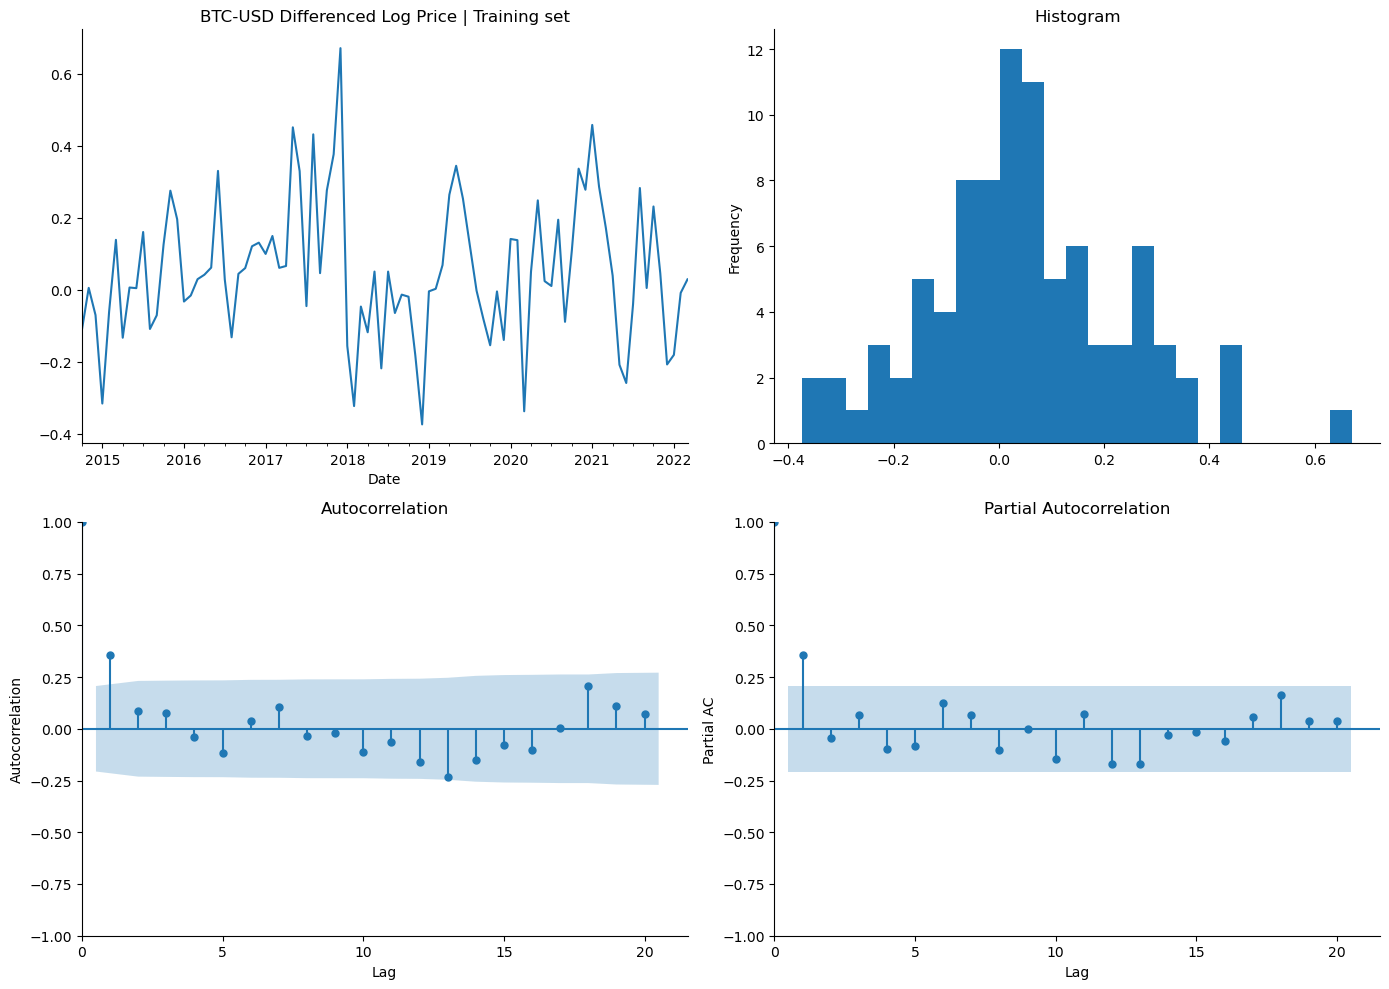

In [19]:
tsplot(train['diff_log'][1:], title='BTC-USD Differenced Log Price | Training set', lags=20, figsize=(14, 10))

From the above histogram, we can see that the differenced log price seem to be close to a normally distributed series.

The ACF plot and the PACF plot now give a clearer picture: only the first spike lies beyond the bands for both plots, giving the initial estimates of p = 1, q = 1, and d = 1.

(The series is differenced once, hence the order of d is 1.)

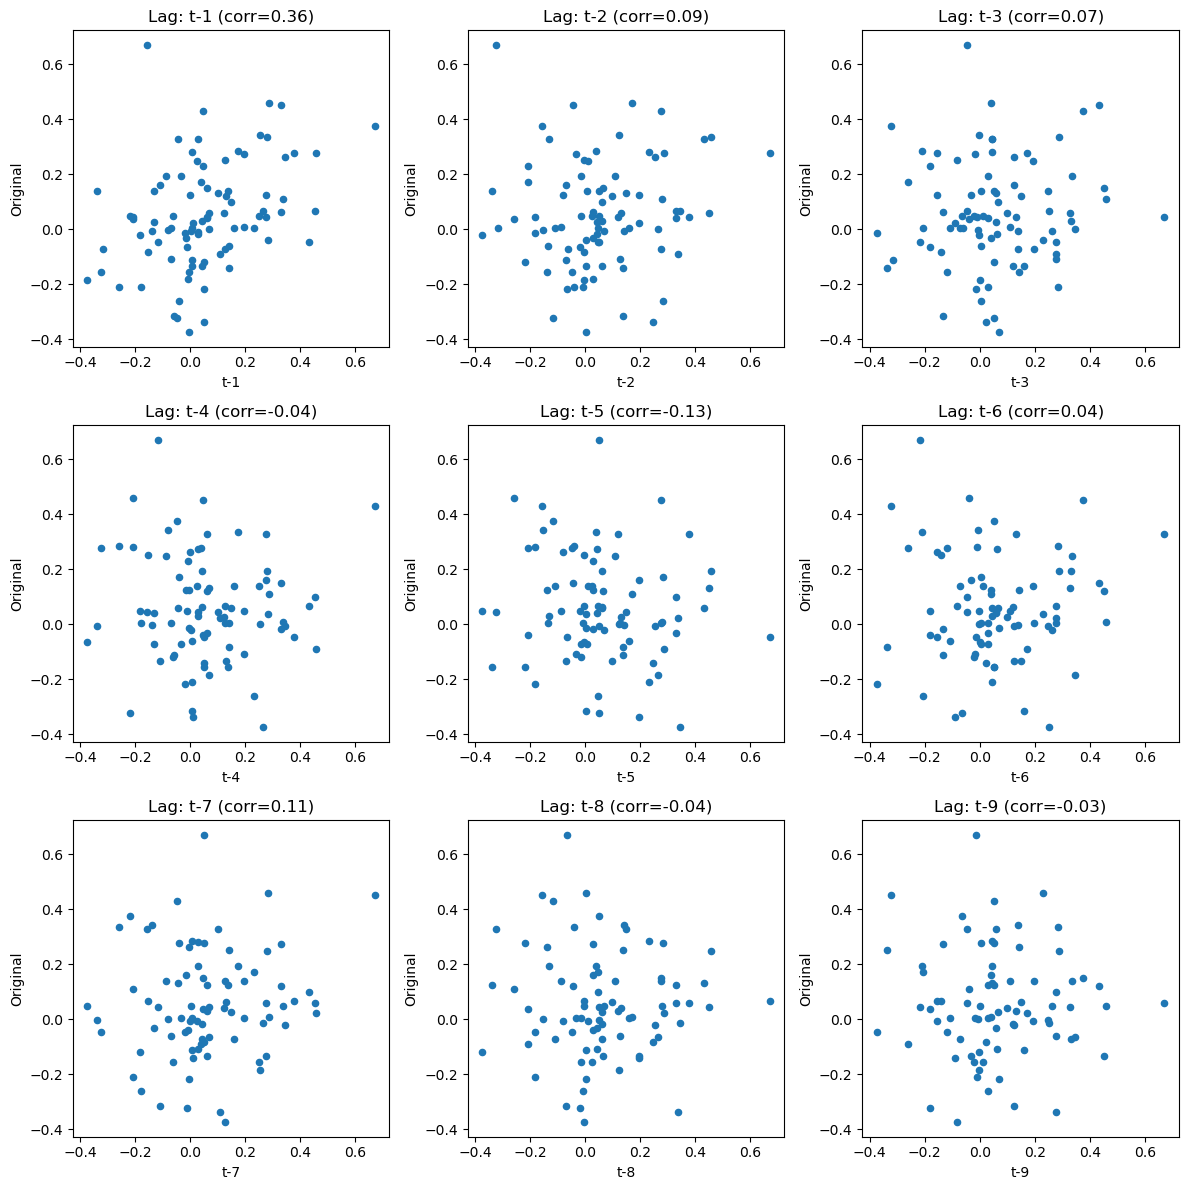

In [20]:
# scatterplot matrix to visualize autocorrelations

lags = 9

ncols = 3
nrows = int(np.ceil(lags/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize = (4*ncols, 4*nrows))

for ax, lag in zip(axes.flat, np.arange(1, lags+1, 1)):
    lag_str = f"t-{lag}"
    X = (pd.concat([train['diff_log'][1:], train['diff_log'][1:].shift(-lag)], axis=1, keys=['y']+[lag_str]).dropna())
    X.plot(ax=ax, kind='scatter', y='y', x=lag_str)
    corr = X.corr().values[0][1]
    ax.set_ylabel('Original')
    ax.set_title(f"Lag: {lag_str} (corr={corr:.2f})")
    ax.set_aspect('equal')
    sns.despine

fig.tight_layout()

The scatterplot matrix of autocorrelations is another way of visualizing the autocorrelations of the series with previous lags.

We can see that there is no obvious linear relationship in any scatterplot in the matrix, suggesting that the differenced log prices show very little autocorrelations with lags up to 9.

### ARIMA Fitting - Model Grid Search

Fixating at d=1, the possible ranges of values of p and q are quite limited. With such limited combinations, I choose to do a grid search on all possible combinations of parameters, shown as follows.

Then I choose the ARIMA model with the least BIC, which uses the in-sample data for evaluations. The AIC values and AICc values are also calculated for reference.

In [21]:
# combinations of parameters
ps = range(0, 5)
qs = range(0, 5)
d = 1

parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

25

In [22]:
# fitting models
results = pd.DataFrame(columns=['parameters', 'AIC', 'AICc', 'BIC'])

for param in parameters_list:
    try:
        model = SARIMAX(
            train['log_price'].dropna(),
            order=(param[0], d, param[1]),
            trend="c"
        )
        model_fit = model.fit(disp=0)
    except ValueError:
        print('wrong parameters:', param)
        continue
    results.loc[len(results.index)] = [(param[0], d, param[1]), model_fit.aic, model_fit.aicc, model_fit.bic]

In [23]:
# models sorted by ascending values of BIC
results.sort_values(by=['BIC'], ascending=True, ignore_index=True).head(10)

,parameters,AIC,AICc,BIC
0,"(0, 1, 1)",-48.625141,-48.346072,-41.125712
1,"(1, 1, 0)",-48.504466,-48.225396,-41.005037
2,"(1, 1, 1)",-46.846513,-46.375925,-36.847275
3,"(0, 1, 2)",-46.769092,-46.298504,-36.769854
4,"(2, 1, 0)",-46.699804,-46.229216,-36.700566
5,"(2, 1, 1)",-47.728698,-47.014412,-35.229649
6,"(0, 1, 0)",-38.354868,-38.216937,-33.355248
7,"(0, 1, 3)",-45.454646,-44.740360,-32.955597
8,"(3, 1, 0)",-45.146696,-44.432411,-32.647648
9,"(1, 1, 2)",-45.014463,-44.300178,-32.515415


The ARIMA(0, 1, 1) model has the least BIC value.

In [24]:
results.sort_values(by=['parameters'], ascending=True, ignore_index=True)

results_bic = pd.DataFrame(
                      index=[f"AR{i}" for i in ps],
                      columns=[f"MA{i}" for i in qs]
                )

for i in results.index:
    results_bic.loc[f"AR{results['parameters'][i][0]}", f"MA{results['parameters'][i][2]}"] = results.loc[i, 'BIC']

results_bic = results_bic[results_bic.columns].astype(float)

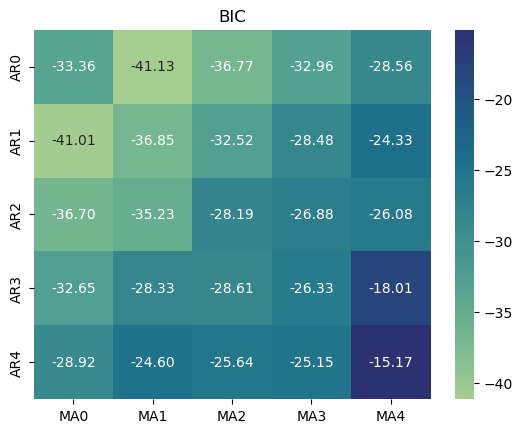

In [25]:
fig, ax = plt.subplots()
sns.heatmap(results_bic,
            ax=ax,
            annot=True,
            fmt='.2f',
            cmap='crest')
ax.set_title('BIC')
plt.show()

We can also visualize the BIC values of the models using a heatmap. Again, the ARIMA(0, 1, 1) model has the least BIC value.

I will use the ARIMA(0, 1, 1) model for forecasting below.

## 3. Model Diagnostics - Out-of-sample Evaluations, Residual Diagnostics

Before doing the forecast, I evaluate the model with held-out data and also evaluate the residuals of the model.

Notice that the ARIMA(0, 1, 1) model is fitted to the log price series.

In [26]:
model = SARIMAX(
            train['log_price'],
            order=(0, 1, 1),
            trend="c"
        )
model_fit = model.fit(disp=0)

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              log_price   No. Observations:                   91
Model:               SARIMAX(0, 1, 1)   Log Likelihood                  27.313
Date:                Wed, 27 Mar 2024   AIC                            -48.625
Time:                        01:49:47   BIC                            -41.126
Sample:                    09-01-2014   HQIC                           -45.601
                         - 03-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0508      0.026      1.945      0.052      -0.000       0.102
ma.L1          0.3664      0.088      4.186      0.000       0.195       0.538
sigma2         0.0319      0.004      7.116      0.000       0.023       0.041
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.37
Prob(Q):                              0.87   Prob(JB):                         0.51
Heteroskedasticity (H):               2.00   Skew:                             0.25
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Out-of-sample Evaluations: MAE, MAPE, RMSE

Here, I calculate the MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error) and RMSE (Root Mean Squared Erro) of the model using both the in-sample data and the held-out data.

The main metric for the out-of-sample evaluation I use here is the Test MAPE. Other metrics are also listed here for reference.

In [27]:
pred_begin = train.index[0]
pred_end = test.index[-1]
pred = model_fit.get_prediction(start=pred_begin,
                                end=pred_end)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

In [28]:
train_mae = mean_absolute_error(train['price'], pred_mean[train.index])
test_mae = mean_absolute_error(test['price'], pred_mean[test.index])
train_mape = mean_absolute_percentage_error(train['price'], pred_mean[train.index])
test_mape = mean_absolute_percentage_error(test['price'], pred_mean[test.index])
train_rmse = mean_squared_error(train['price'], pred_mean[train.index], squared=False)
test_rmse = mean_squared_error(test['price'], pred_mean[test.index], squared=False)

print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")
print(f"\nTrain MAPE: {train_mape:.3f}%")
print(f"Test MAPE: {test_mape:.3f}%")
print(f"\nTrain RMSE: {train_rmse:.3f}")
print(f"Test RMSE: {test_rmse:.3f}")

Train MAE: 11699.002
Test MAE: 28429.567

Train MAPE: 0.994%
Test MAPE: 1.000%

Train RMSE: 20046.200
Test RMSE: 29724.239


As the BTC-USD prices have changed drastically throughout the period of the data, it might be misleading to look at MAE and RMSE. The better metric here might be (Test) MAPE, which is 1.000%.

### Residual Diagnostics

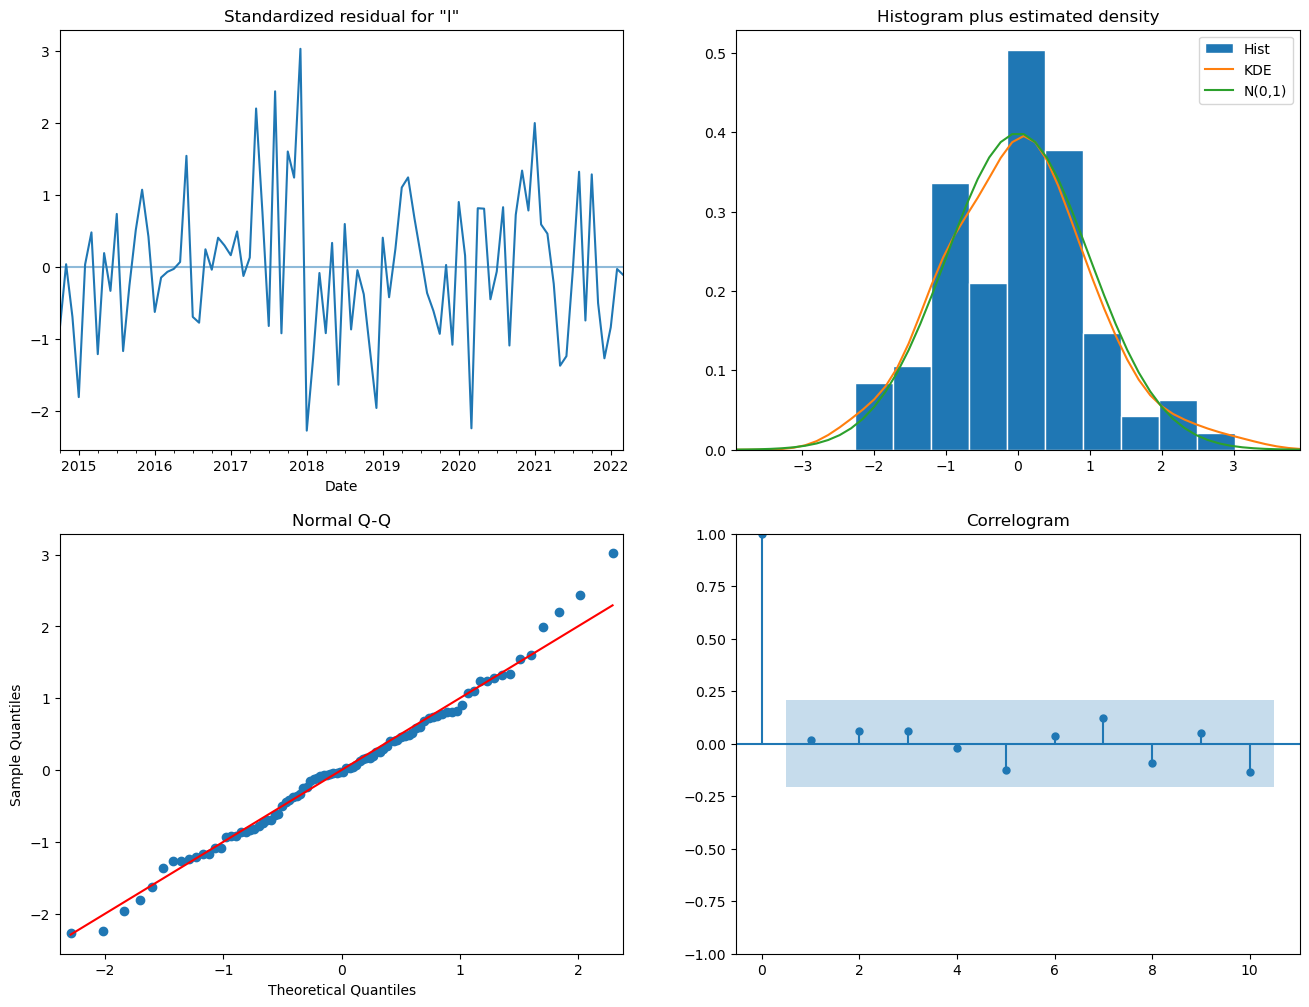

In [29]:
model_fit.plot_diagnostics(figsize=(16, 12))
plt.show()

From the histogram above, the residuals seem to have some traits of a normal distribution, but the values between -1 and 0 make it seem less likely then. Further statistical testing is needed.

In the correlogram, there is no spike lying beyond the bands for lag 1 to lag 10, suggesting that there seems to be no autocorrelation in the residuals.

### Formal Testing

Apart from the visual inspection above, we can also carry out formal statistical tests.

I use the following two tests:

- Test for Normality: Shapiro-Wilk
- Test for Serial Correlation: Ljung-Box

In [30]:
norm_method = 'shapiro-wilk'
sercor_method = 'ljungbox'

# test for normality
norm_stat, norm_p = stats.shapiro(model_fit.resid)

# test for serial correlation
sercor_stat, sercor_p = model_fit.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

print(f"\nTest normality of residuals ({norm_method}): stat={norm_stat:.3f}, p={norm_p:.3f}")
print(f"\nTest serial correlation of residuals ({sercor_method}): stat={sercor_stat:.3f}, p={sercor_p:.3f}")


Test normality of residuals (shapiro-wilk): stat=0.285, p=0.000

Test serial correlation of residuals (ljungbox): stat=6.900, p=0.735


The p-value for Shapiro-Wilk Test is 0.000, which is far less than 0.05. This rejects $H_0$ at 5% significance that the residuals are normally distributed.

The p-value for Ljung-Box Test is 0.735, which is greater than 0.05. This fails to reject $H_0$ at 5% significance that the residuals are not autocorrelated.

# Forecasting

Now, I will make a forecast using the ARIMA(0, 1, 1) model. I will make both point forecasts and interval forecasts.

As the series are log transformed prices, I have to do back-transformations on all the point forecasts and interval forecasts to get the corresponding forecasts for the BTC-USD prices.

In [31]:
exp_pred_mean = np.exp(pred_mean[1:])
exp_pred_ci = np.exp(pred_ci[1:])
exp_pred_ci.rename(columns={'lower log_price': 'lower price', 'upper log_price':'upper price'}, inplace=True)

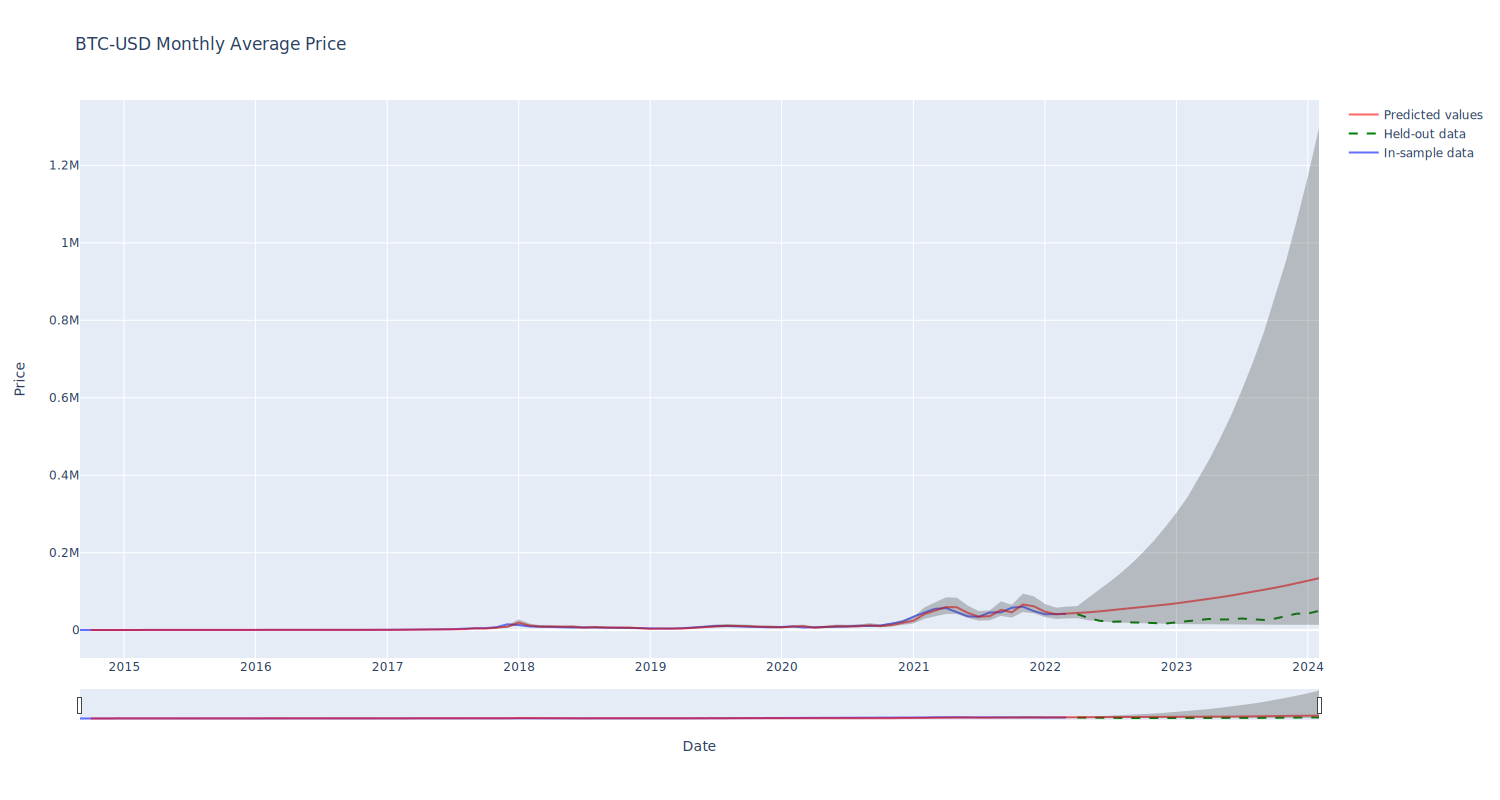

In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train["price"], mode='lines', name="In-sample data"))
fig.add_trace(go.Scatter(x=test.index, y=test["price"], line = dict(color='green', dash='dash'), name="Held-out data"))

# point predictions
fig.add_trace(go.Scatter(x=exp_pred_mean.index, y=exp_pred_mean, line = dict(color='red'), opacity=0.6, name="Predicted values"))

# interval predictions
fig.add_traces([go.Scatter(
                      x=exp_pred_ci.index,
                      y=exp_pred_ci['upper price'],
                      mode='lines',
                      marker=dict(color="#444"),
                      line=dict(width=0),
                      name='Upper bound',
                      showlegend = False
                    ),
                go.Scatter(
                      x=exp_pred_ci.index,
                      y=exp_pred_ci['lower price'],
                      mode='lines',
                      marker=dict(color="#444"),
                      line=dict(width=0),
                      fill='tonexty',
                      fillcolor='rgba(68, 68, 68, 0.3)',
                      name='Lower bound',
                      showlegend = False
                    )
                ])

fig.update_layout(
            yaxis_title="Price",
            xaxis_title="Date",
            title="BTC-USD Monthly Average Price",
            hovermode="x unified",
            width=1500,
            height=800
          )
fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness = 0.05)
fig.show(renderer="svg")

After the back-transformations, the prediction interval becomes asymmetrical.

The exponentiation of the intervals can amplify the predicted errors, therefore the upper limit of the interval can become drastically larger than the predicted mean.

In the above example, the interval prediction at Feb 2024 is the range 14k to 1.3M.

The held-out data fall within the interval prediction, but as the interval is very wide, it is hard to say that it provides a very useful forecast.

This is one of the shortfalls of using the above forecast modelling to fit into a series that are very volatile and constantly changing in the real world.

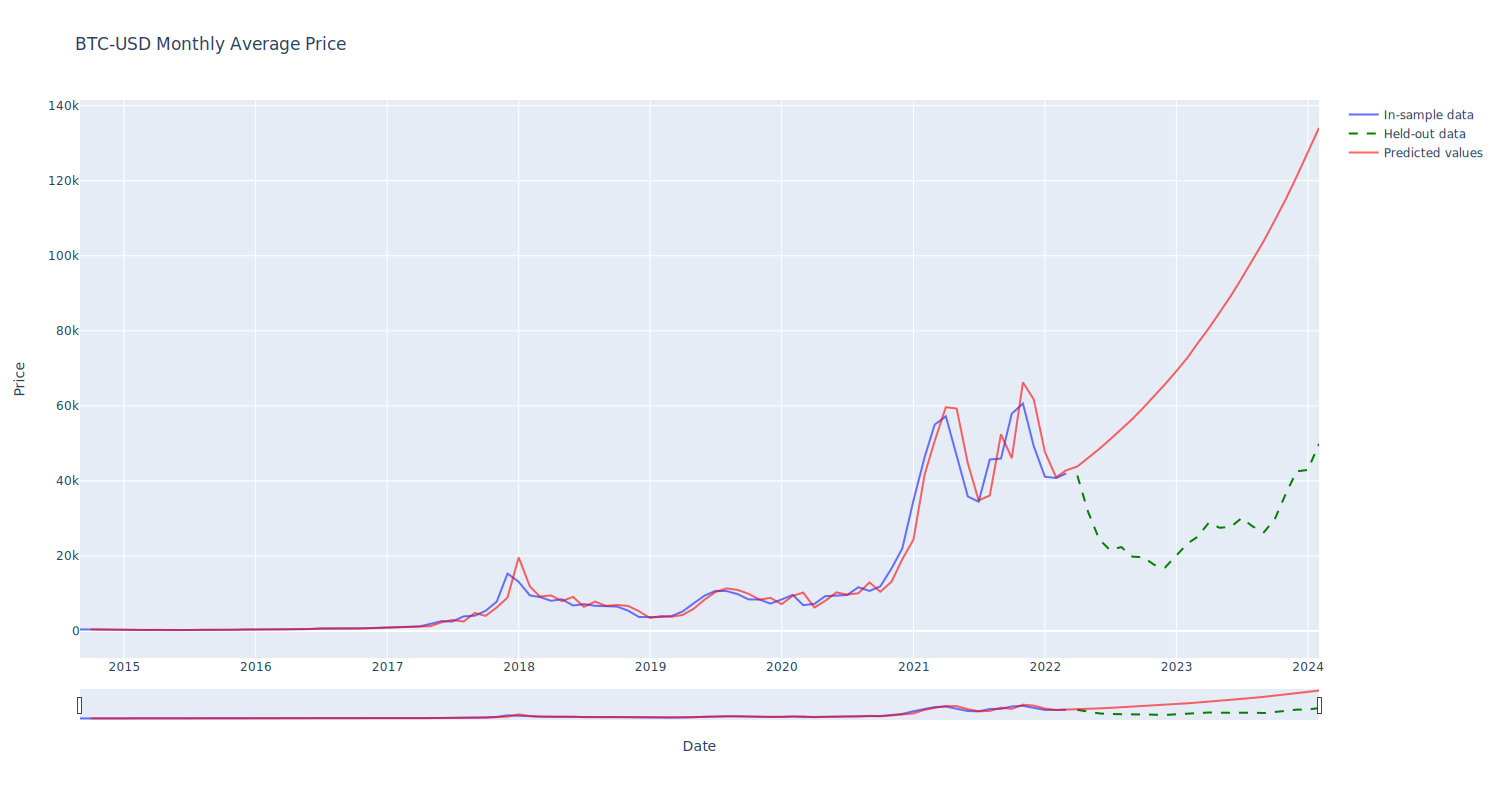

In [33]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train["price"], mode='lines', name="In-sample data"))
fig.add_trace(go.Scatter(x=test.index, y=test["price"], line = dict(color='green', dash='dash'), name="Held-out data"))

# point predictions
fig.add_trace(go.Scatter(x=exp_pred_mean.index, y=exp_pred_mean, line = dict(color='red'), opacity=0.6, name="Predicted values"))

fig.update_layout(
            yaxis_title="Price",
            xaxis_title="Date",
            title="BTC-USD Monthly Average Price",
            hovermode="x unified",
            width=1500,
            height=800
          )
fig.update_xaxes(rangeslider_visible=True, rangeslider_thickness = 0.05)
fig.show(renderer="svg")

Taking away the interval predictions and zooming in, the point forecasts are not able to capture the shape of the held-out data but give an exponential trend forecast. This is probably due to the limitation of the ARIMA model itself. However, it could still give a rough estimation of the trend as if there was an underlying exponential trend and a mean reversion might eventually occur in the future, despite the huge range of possible volatilities.